# Building an aspect-based sentiment analysis algorithm based on syntactic parsing

                                                                                    - Yash Kasundra
                                                                                    - A1838670

### Importing Libraries

In [1]:
# imports

import sys
import re
import math
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import operator
from math import sqrt
from statistics import mean
from scipy.sparse import csr_matrix


import spacy
nlp = spacy.load("en_core_web_sm")

import nltk
from nltk import stem  
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet

import collections
from collections import Counter
import itertools
from itertools import islice
from itertools import chain
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np 
from numpy import mean
from numpy import std

import sklearn
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.models import Sequential
from keras import layers

import random
seed_value = 100
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# nltk downloads
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\anil\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Loading and creating Dataframe from XML file

In [2]:
def XML_processing(file):

    # get root
    root = ET.parse(file).getroot()

    id = []
    term = {}     # Review wise aspect term
    polarity = {} # Polarities for a review
    text_review = []

    for item in root.findall('sentence'):    
        id_val = item.get('id')
        id.append(id_val)

    total_reviews = len(id) 
 
  #  <review text>
    for i in range(0,total_reviews):
        text_review.append(root[i][0].text)

  #  <aspect term>
    for i in range (0, total_reviews):
        aspect_terms = root[i][1]

  # get term and polarity
        for item in aspect_terms.findall('aspectTerm'):
            term_value = item.get('term')
            polarity_value = item.get('polarity')
        
            if i not in term:
                term[i] = [term_value]
                polarity[i] = [polarity_value]
            
            else:
                term[i].append( term_value)
                polarity[i] .append(polarity_value)
  
    return total_reviews,text_review,term,polarity;


In [3]:
total_reviews,text_review,term,polarity = XML_processing('Restaurants.xml')

print("Total no, of reviews: ",total_reviews)
print("Reviews containing aspect term: ", len(term))
print("Some reviews: ",text_review[0:5])


Total no, of reviews:  3041
Reviews containing aspect term:  2021
Some reviews:  ['But the staff was so horrible to us.', "To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.", "The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not.", 'Where Gabriela personaly greets you and recommends you what to eat.', "For those that go once and don't enjoy it, all I can say is that they just don't get it."]


In [4]:
# function to return only unique words in a sentence
def unique_list(line):
  
    ulist = []
    [ulist.append(x) for x in line if x not in ulist]
    return ulist



In [5]:
# function to extract relevant info with dependency parsing and return a dict of text and polarity for a review
def get_DictData(term, text_review, polarity): 

    index_list = []    # store index of review 
    polarity_and_description = {} # dict to store the final description and its polarity

    for key,val in term.items():
        index_list.append(key)

    for i in index_list: # for each index

        review = text_review[i]
        aspect_term_list = term[i]
        polar_list = polarity[i]
        doc = nlp(review)        # spacy
    
        for k,item in enumerate(aspect_term_list):  
            single_term = len(item.split())      # get a single aspect terms in a review

            if  single_term > 1:                 # if aspect term contains more than one word, keep the first word
                item_ = item.split(' ', 1)[0]
                aspect_term_list[k] = item_       # change the orginal term in the list

        j = 0
        word_type = []
        description = ' '
        description_dict = {}

        for token in doc:                       # for each word in review
            if token.text in aspect_term_list:  # if word is an aspect term

                aspect_item = token.text
                head = token.head

                child_head = head.children     # get all child text of head
                child_token = token.children   # get all child text of token

                for child_ in  token.children:
                    description = description + " " + str(child_) # add child text of token to description
            
                for child in child_head:
                    child = str(child)

                    if j not in  description_dict:
                        description_dict[j] = [child] # store child text in a dict as list
                    else:
                        description_dict[j].append(child)

                description_dict[j].append(description)  # store child text of both token and head for an aspect term

                j+=1 
                description = ' '   

        descript_joined = []

        for key,val in  description_dict.items(): # combine the words stored in list to form a single text sentence
            value = ' '.join(val)
            value = ' '.join(unique_list(value.split())) # remove repeated words
            descript_joined.append(value) 

        for key,val in zip(polar_list, descript_joined): 
            polarity_and_description[val] = key   # store description and polarity in a dict

    return polarity_and_description


In [6]:
all_data = get_DictData(term,text_review,polarity)
print(len(all_data))  

3339


In [7]:
# Making a dataframe from the data
df = pd.DataFrame(list(all_data.items()),columns = ['text','sentiment']) 
print("Data shape: ",df.shape) 


Data shape:  (3339, 2)


In [8]:
# Now lets make a train test split where testing data is 30% of the total data 
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=77)

In [9]:
print("Training data shape: ",df_train.shape) 
print("Testing data shape: ", df_test.shape)

Training data shape:  (2337, 2)
Testing data shape:  (1002, 2)


In [10]:
# Only data useful to us is that where sentiment are not conflicted so let's check how much relavant data we have 
df_train = df_train[df_train.sentiment != "conflict"]
df_test = df_test[df_test.sentiment != "conflict"]

print("Training data shape: ",df_train.shape) 
print("Testing data shape: ", df_test.shape)

Training data shape:  (2273, 2)
Testing data shape:  (979, 2)


In [11]:
# Now lets take a look at first 10 train and test samples
df_train[0:10]

,text,sentiment
2791,who cuisine at fine,positive
988,Pizza crust like ! - pizza,positive
1890,priced well,positive
573,a good wine,positive
1267,and prices mediocre . the here,neutral
2462,service great in,positive
260,ca n't wait head the building,negative
1696,Crab Shuizhu -,positive
1648,affordable !,positive
1835,", slice oily and burnt . the",positive


In [12]:
# Now lets take a look at first 10 train and test samples
df_test[0:10]

,text,sentiment
634,people obviously pizzas their,positive
1325,"is , tapas always yummy with . the",positive
1980,the same classical made,positive
743,"dinner a late , raucus",positive
929,the lamb and naan,positive
805,6 for and mushrooms the 12,positive
2774,place as . The entire and treatment,negative
2326,An excellent,positive
2099,dim,positive
771,"that pizza actually a margarite with , like",neutral


### Pre-processing the data

In [13]:
# function to remove puntuation
def puntuation_removal(text):
    text = [word for word in text if word.isalpha()] #  remove all puntuation and numbers
    return text 

# function to remove stop word from text
def stopwords_removal(text):
    stop_words = list(stopwords.words('english')) # store nltk stopwords
    text = [word for word in text if not word in stop_words] 
    return text 

# function to perform lemmatization
def lemmatization (text):
    lemmatizer = stem.WordNetLemmatizer() 
    text = [lemmatizer.lemmatize(token) for token in text]
    return text 


# function to perform text preprocessing (lemmatization and no stemming)
def clean_corpus(text):
    
    text = text.lower()                # lower case  
    token = word_tokenize(text)         # tokenise
  
    token = stopwords_removal(token)    # remove stopwords
    token = puntuation_removal(token)   # remove puntuation 
    token = lemmatization(token)       # lemmatize

    final_token = " ".join(token)       # join all tokens

    return final_token

In [14]:
# preprocess training data
df_train['processed_text'] = df_train.text.apply(lambda x: clean_corpus(x))

# preprocess test data
df_test['processed_text'] = df_test.text.apply(lambda x: clean_corpus(x))


In [15]:
# remove duplicated sentences
df_train = df_train.drop_duplicates(subset = 'processed_text' , keep = "first")
df_test = df_test.drop_duplicates(subset = 'processed_text' , keep = "first")

print("Training data shape: ",df_train.shape) 
print("Testing data shape: ", df_test.shape)

Training data shape:  (1860, 3)
Testing data shape:  (854, 3)


In [16]:
# remove sentences with only one word, as they do not have any sentiment description term
text_length = []
text_length_test = []

for text in df_train['processed_text']:
    text_length.append(len(text.split()))

for text in df_test['processed_text']:
    text_length_test.append(len(text.split()))

df_train['text_length'] = text_length
df_test['text_length'] = text_length_test

df_train = df_train[df_train.text_length != 1]
df_test = df_test[df_test.text_length != 1]

print(df_train.shape)
print(df_test.shape)


(1544, 4)
(673, 4)


In [17]:
df_train = df_train[['text', 'processed_text', 'text_length', 'sentiment']]
df_test = df_test[['text', 'processed_text', 'text_length', 'sentiment']]

In [18]:
# let's look at few samples from train
df_train[0:10]

,text,processed_text,text_length,sentiment
2791,who cuisine at fine,cuisine fine,2,positive
988,Pizza crust like ! - pizza,pizza crust like pizza,4,positive
1890,priced well,priced well,2,positive
573,a good wine,good wine,2,positive
1267,and prices mediocre . the here,price mediocre,2,neutral
2462,service great in,service great,2,positive
260,ca n't wait head the building,ca wait head building,4,negative
1696,Crab Shuizhu -,crab shuizhu,2,positive
1835,", slice oily and burnt . the",slice oily burnt,3,positive
2132,pizza great all their,pizza great,2,positive


In [19]:
df_test[0:10]

,text,processed_text,text_length,sentiment
634,people obviously pizzas their,people obviously pizza,3,positive
1325,"is , tapas always yummy with . the",tapa always yummy,3,positive
1980,the same classical made,classical made,2,positive
743,"dinner a late , raucus",dinner late raucus,3,positive
929,the lamb and naan,lamb naan,2,positive
2774,place as . The entire and treatment,place entire treatment,3,negative
771,"that pizza actually a margarite with , like",pizza actually margarite like,4,neutral
2358,"servings , i salmon had Small for entree",serving salmon small entree,4,negative
1739,ambience authentic and received The,ambience authentic received,3,positive
277,dish favorite and get This,dish favorite get,3,positive


In [20]:
# function to get word count of a dataset
def word_count(dataset):
    
    unique_words = [] 
    
    for row in dataset:
        for word in row.split(" "):
            if len(word) > 2 and word not in unique_words:
                unique_words.append(word) # Add each unique word of length > 2 to the list
            
    unique_words.sort()
    vocab = {j:i for i,j in enumerate(unique_words)} # Enumerate the list, i.e., give consecutive numbers to each item, store in a dict
    return vocab


In [21]:
 #let's comapre total number of unique words in training set before and after processing
unique_words_ques2 = word_count(df_train['processed_text'])
print("Number of unique words in processed training text: ",len(unique_words_ques2))  

unique_words_ = word_count(df_train['text'])
print("Number of unique words in original training text: ",len(unique_words_))   

Number of unique words in processed training text:  1282
Number of unique words in original training text:  1618


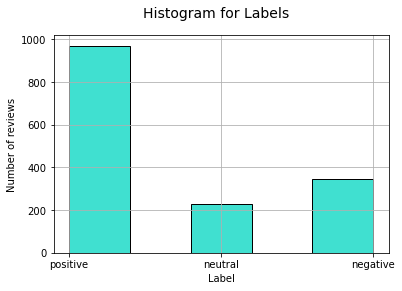

In [22]:

# plot distribution of label in training data
df_train['sentiment'].hist(edgecolor = 'black',bins=5,facecolor = 'turquoise')
plt.suptitle("Histogram for Labels",size = 14)
plt.xlabel("Label")
plt.ylabel("Number of reviews")
plt.show()

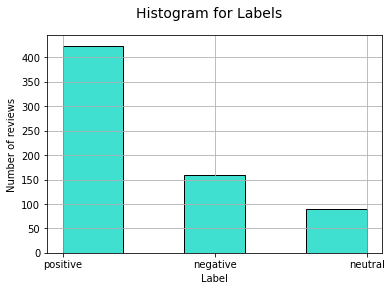

In [23]:
# plot distribution of label in test data
df_test['sentiment'].hist(edgecolor = 'black',bins=5,facecolor = 'turquoise')
plt.suptitle("Histogram for Labels",size = 14)
plt.xlabel("Label")
plt.ylabel("Number of reviews")
plt.show()

### Now after pre-processing our data, it is clean. So let's start with applying classification models like Logistic Regression, Multinomial Navie Bayes and SVC. For that we will first use TF-IDF to convert our data into vectors and then pass it into those model with a grid search.

In [24]:
y_test = df_test['sentiment']

   - TF-IDF

In [25]:
# TF-IDF transformation
vectorizer = TfidfVectorizer()
vectorizer.fit(df_train['processed_text'])

tfidf_X_train = vectorizer.transform(df_train['processed_text'])
tfidf_X_test = vectorizer.transform(df_test['processed_text'])

print(vectorizer.get_feature_names_out())

print("Training feature shape", tfidf_X_train.shape)
print("Testing feature shape", tfidf_X_test .shape)

['absolutely' 'accomodating' 'accompaniment' ... 'yummy' 'ziti' 'zucchini']
Training feature shape (1544, 1295)
Testing feature shape (673, 1295)


In [26]:
# split training data into training and validation set where validation is 20% of training data
x_train, x_valid, y_train, y_valid = train_test_split(tfidf_X_train , df_train['sentiment'], test_size=0.2, random_state=42,shuffle = True)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)

(1235, 1295)
(1235,)
(309, 1295)


   - Grid Search

In [27]:
# function to perform grid search for some_parameters 
def do_GridSearch(model, some_parameters):

    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
    search = GridSearchCV(model, some_parameters, scoring='accuracy', n_jobs=-1, cv=cv)

    result = search.fit(x_train, y_train)

  # print summary
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    print()

    means = result.cv_results_['mean_test_score']
    stds = result.cv_results_['std_test_score']

    for mean, std, params in zip(means, stds, result.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

    return result.best_score_ 

   - Logistic Regression

In [28]:
logisticreg =  LogisticRegression(multi_class='multinomial')

parameters = {'solver':  ['lbfgs','newton-cg' , 'sag','saga'] ,  'C': [0.01,0.1,0.5,1.0,1.5], 'tol':[0.0001,0.001, 0.01,0.1]}
best_score_log_reg = do_GridSearch(logisticreg, parameters)

Best Score: 0.6680161943319838
Best Hyperparameters: {'C': 1.5, 'solver': 'sag', 'tol': 0.1}

0.629 (+/-0.004) for {'C': 0.01, 'solver': 'lbfgs', 'tol': 0.0001}
0.629 (+/-0.004) for {'C': 0.01, 'solver': 'lbfgs', 'tol': 0.001}
0.629 (+/-0.004) for {'C': 0.01, 'solver': 'lbfgs', 'tol': 0.01}
0.629 (+/-0.004) for {'C': 0.01, 'solver': 'lbfgs', 'tol': 0.1}
0.629 (+/-0.004) for {'C': 0.01, 'solver': 'newton-cg', 'tol': 0.0001}
0.629 (+/-0.004) for {'C': 0.01, 'solver': 'newton-cg', 'tol': 0.001}
0.629 (+/-0.004) for {'C': 0.01, 'solver': 'newton-cg', 'tol': 0.01}
0.629 (+/-0.004) for {'C': 0.01, 'solver': 'newton-cg', 'tol': 0.1}
0.629 (+/-0.004) for {'C': 0.01, 'solver': 'sag', 'tol': 0.0001}
0.629 (+/-0.004) for {'C': 0.01, 'solver': 'sag', 'tol': 0.001}
0.629 (+/-0.004) for {'C': 0.01, 'solver': 'sag', 'tol': 0.01}
0.629 (+/-0.004) for {'C': 0.01, 'solver': 'sag', 'tol': 0.1}
0.629 (+/-0.004) for {'C': 0.01, 'solver': 'saga', 'tol': 0.0001}
0.629 (+/-0.004) for {'C': 0.01, 'solver': 'sa

   - Multinomial Naive Bayes

In [29]:
naivebayes  = MultinomialNB()
parameters = {'alpha': [0.001, 0.01,0.1,0.5,1.0,1.2]}
best_score_navie_bayes = do_GridSearch(naivebayes, parameters)

Best Score: 0.6510121457489879
Best Hyperparameters: {'alpha': 0.5}

0.609 (+/-0.033) for {'alpha': 0.001}
0.619 (+/-0.038) for {'alpha': 0.01}
0.640 (+/-0.035) for {'alpha': 0.1}
0.651 (+/-0.016) for {'alpha': 0.5}
0.636 (+/-0.013) for {'alpha': 1.0}
0.633 (+/-0.014) for {'alpha': 1.2}


   - Support Vector Classifier

In [30]:
svc = SVC()
parameters = {'kernel':  ['rbf', 'poly','sigmoid'] , 'C': [0.1,0.5,1.0,5,10], 'gamma': [0.0001,0.001,0.01,0.1]}
best_score_SVC = do_GridSearch(svc, parameters)

Best Score: 0.668825910931174
Best Hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}

0.629 (+/-0.004) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.629 (+/-0.004) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
0.629 (+/-0.004) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.629 (+/-0.004) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.629 (+/-0.004) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.629 (+/-0.004) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.629 (+/-0.004) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.629 (+/-0.004) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.629 (+/-0.004) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.629 (+/-0.004) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.629 (+/-0.004) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.629 (+/-0.004) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.629 (+/-0.004) for {'C': 0.5, 'gamma': 0.0001, 'kernel': 'rbf'}
0.629 (+/-0.004) for {'C': 0.5, 'gamma': 0

#### Let's compare the best scores for all 3 models

In [31]:
from tabulate import tabulate

table = [['Classification Models', 'Best Scores from Grid search'], 
         ['Logistic Regression', best_score_log_reg], 
         ['Multinomial Naive Bayes', best_score_navie_bayes],
         ['Support Vector Classifier', best_score_SVC]]

In [32]:
print(tabulate(table))

-------------------------  ----------------------------
Classification Models      Best Scores from Grid search
Logistic Regression        0.6680161943319838
Multinomial Naive Bayes    0.6510121457489879
Support Vector Classifier  0.668825910931174
-------------------------  ----------------------------


### Ler's Use logistic regression model to evaluate the model performance on test set

In [33]:
model = LogisticRegression(multi_class='multinomial',C = 1.5, solver= 'lbfgs', tol =  0.0001, random_state=77) 
model.fit(x_train, y_train)
y_pred = model.predict(tfidf_X_test) #tfidf_X_test

accuracy_score(y_pred, y_test) 

0.6775631500742942

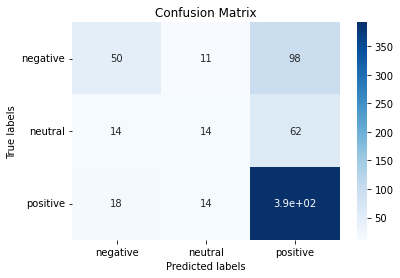

In [34]:
# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap='Blues'); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ "negative", "neutral","positive"]);
ax.yaxis.set_ticklabels(["negative", "neutral","positive"],rotation = 0);

### After checking the performance of all those classification models, it's good performance but it's not the best. So in order to achieve better performance let's dive into Neural networks. I would be using Convolutional neural networks and Long short-term memory (LSTM) models and then compare their performances.

In [35]:
# test label
y_test = pd.get_dummies(df_test['sentiment'])
y_test = y_test.values

# all training label
y = pd.get_dummies(df_train['sentiment'])
label = y.values
label

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [36]:
print(df_train.describe())
print()
print(df_test.describe())

       text_length
count  1544.000000
mean      2.654145
std       0.863801
min       0.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       6.000000

       text_length
count   673.000000
mean      2.677563
std       0.903886
min       0.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       6.000000


In [37]:
from tensorflow.keras.preprocessing import text

x = df_train['processed_text'].values

max_features = 1500         # most freq 1500 words in the dataset would be kept
max_text_length = 8        # as  max text length = 8

# change each text into a sequence of integers, each integer being index of token in a dictionary
tokenizer_x = text.Tokenizer(max_features)
tokenizer_x.fit_on_texts(list(x))
tokenized_x = tokenizer_x.texts_to_sequences(x)
all_x_training = sequence.pad_sequences(tokenized_x,maxlen = max_text_length)#padding

all_x_training

array([[   0,    0,    0, ...,    0,   86,   53],
       [   0,    0,    0, ...,  218,   29,   18],
       [   0,    0,    0, ...,    0,   54,   38],
       ...,
       [   0,    0,    0, ...,    0,    1,   91],
       [   0,    0,    0, ...,    0, 1295, 1296],
       [   0,    0,    0, ...,  140, 1297,    9]])

In [38]:
#tokenise and pad the text  with zeros to match the length
tokenized_x_test = tokenizer_x.texts_to_sequences(df_test['processed_text'].values)
x_testing = sequence.pad_sequences(tokenized_x_test,maxlen = max_text_length) 

x_testing

array([[  0,   0,   0, ...,   0,  55,  18],
       [  0,   0,   0, ...,   0,  21, 141],
       [  0,   0,   0, ...,   0,   0, 107],
       ...,
       [  0,   0,   3, ...,   2, 739, 463],
       [  0,   0,   0, ...,   0,  38, 247],
       [  0,   0,   0, ...,   0, 265, 517]])

In [39]:
# open glove and store word embeddings
embedding_dim = 100
embeddings_index = dict()

f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype = 'float32') #store all excepy val[0]
    embeddings_index[word] = coefs                  #populate embedding dict
    
f.close()

print(f'Found {len(embeddings_index)} word vectors') 

Found 400000 word vectors


In [40]:
# prepare embedding_matrix

matrix_embeddings = np.zeros((max_features,embedding_dim))

for word,index in tokenizer_x.word_index.items():
    
    if index> max_features -1: #bounding by max feat
        break
    else:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        matrix_embeddings[index] = embedding_vector

matrix_embeddings.shape

(1500, 100)

In [41]:
print(matrix_embeddings)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.16486     0.91996998  0.22736999 ... -0.067904    1.5072
   0.60889   ]
 [-0.4224     -0.13313    -0.41418001 ... -0.070558    0.12285
   0.43399999]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [42]:
# split data into training and vslidation set
x_train, x_valid, y_train, y_valid = train_test_split(all_x_training ,label, test_size=0.2, random_state=77, shuffle = True)

print(x_train.shape)
print(y_train.shape)

print(x_valid.shape)
print(y_valid.shape)

(1235, 8)
(1235, 3)
(309, 8)
(309, 3)


In [43]:
x_train

array([[  0,   0,   0, ...,   0, 444, 786],
       [  0,   0,   0, ..., 167,   3, 204],
       [  0,   0,   0, ...,   0,  13, 922],
       ...,
       [  0,   0,   0, ...,  21,  39, 674],
       [  0,   0,   0, ...,   0,   1,  59],
       [  0,   0,   0, ...,   0,  31,   4]])

In [44]:

# plot accuracy and loss curves
def history_plot(history):
    
    plt.figure(figsize=(8,5),linewidth = 7, edgecolor="whitesmoke")    
    n = len(history.history['accuracy'])
    
    plt.plot(np.arange(0,n)+1,history.history['accuracy'], color='orange',marker=".")
    plt.plot(np.arange(0,n)+1,history.history['loss'],'b',marker=".")
    
    # offset both validation curves
    plt.plot(np.arange(0,n)+ 1,history.history['val_accuracy'],'r')  
    plt.plot(np.arange(0,n)+ 1,history.history['val_loss'],'g')
    
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    
    # set vertical limit to 1
    plt.gca().set_ylim(0,1)

    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle("Learning Curve", size=16, y=0.927)
    plt.show() 


In [45]:
#function to evaluate the model using validation data
def evaluate_models(model_name):
    
    result_val = model_name.evaluate(x_valid, y_valid, verbose=0)
    
    print("Validation set")
    print('loss:', result_val[0])
    print("accuracy:" ,result_val[1])
    
    return result_val[1], result_val[0]
#function to evaluate the model using test data
def evalulate_test_models(model_name):
    
    result_test = model_name.evaluate(x_testing, y_test, verbose=0)
    
    print("Test set")
    print('loss:', result_test[0])
    print("accuracy:" ,result_test[1])
    

In [46]:
# set some parameter values

embedding_dim = 100
max_features = 1500   
actfn = 'relu'
optimizer_ = tf.optimizers.Adam
learningrate = 0.001
batch_size = 20

In [47]:
# function to build the CNN model 
def CNN_Model():
    
    model = Sequential()
    
    #create embedding layer
    model.add(Embedding(max_features, embedding_dim, trainable = False ,embeddings_initializer = tf.keras.initializers.Constant(matrix_embeddings)))  

    # 1st dropout
    model.add(Dropout(0.4))
    
    # 1st convolutional 1-D layer
    model.add(Conv1D(32,3, padding = 'valid',activation = actfn)) #no padding
    
    #max pooling layer
    model.add(MaxPooling1D())
    
    # 2nd convolutional 1-D layer
    model.add(Conv1D(64, 3, padding = 'valid', activation = actfn))
    
    # global max pooling layer
    model.add(GlobalMaxPooling1D())
    
    # 1st dense layer
    model.add(Dense(6,activation = actfn))
    
    # 2nd dropout
    model.add(Dropout(0.4))
    
    # final dense layer
    model.add(Dense(3,activation = 'softmax')) #sigmoid
    
    # compile the model
    model.compile(loss = 'categorical_crossentropy',    
                 optimizer = optimizer_(learning_rate = 0.001),
                 metrics = ['accuracy']) 

    return model

In [48]:
# function to build the LSTM model 
def LSTM_Model():
    
    model = Sequential()
    
    #create embedding layer
    model.add(Embedding(max_features, embedding_dim, trainable = False ,embeddings_initializer = tf.keras.initializers.Constant(matrix_embeddings)))  

    model.add(layers.Bidirectional(layers.LSTM(20, dropout=0.5,activation='tanh')))

    model.add(Dense(10, activation='relu'))

    # final dense layer
    model.add(Dense(3,activation = 'softmax'))
    
    # compile the model
    model.compile(loss = 'categorical_crossentropy',    
                 optimizer = 'rmsprop'     ,   
                 metrics = ['accuracy']) 

    return model


In [49]:
# function to compile and fit the model 
def run_model_functions(actfn, n_epochs, batch_size, model):
    
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1 ,patience= 20, restore_best_weights = True ) 
    
    # fit the model
    history = model.fit(x_train,y_train,
              batch_size = batch_size,
              epochs = n_epochs,
              validation_data=(x_valid,y_valid),
              callbacks=[es] )
    
    return (history, model)

#### Running CNN model

Epoch 1/100
62/62 [==============================] - 5s 12ms/step - loss: 1.0052 - accuracy: 0.6251 - val_loss: 0.9658 - val_accuracy: 0.5955
Epoch 2/100
62/62 [==============================] - 1s 9ms/step - loss: 0.9373 - accuracy: 0.6364 - val_loss: 0.9276 - val_accuracy: 0.5955
Epoch 3/100
62/62 [==============================] - 1s 12ms/step - loss: 0.9370 - accuracy: 0.6364 - val_loss: 0.9153 - val_accuracy: 0.5955
Epoch 4/100
62/62 [==============================] - 1s 10ms/step - loss: 0.9079 - accuracy: 0.6364 - val_loss: 0.8990 - val_accuracy: 0.5955
Epoch 5/100
62/62 [==============================] - 1s 12ms/step - loss: 0.8983 - accuracy: 0.6364 - val_loss: 0.8953 - val_accuracy: 0.5955
Epoch 6/100
62/62 [==============================] - 1s 12ms/step - loss: 0.8877 - accuracy: 0.6372 - val_loss: 0.8787 - val_accuracy: 0.5955
Epoch 7/100
62/62 [==============================] - 0s 7ms/step - loss: 0.8730 - accuracy: 0.6364 - val_loss: 0.8703 - val_accuracy: 0.5955
Epoch 8/

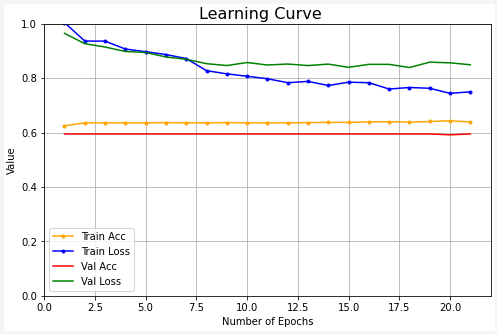


Validation set
loss: 0.9658093452453613
accuracy: 0.5954692363739014


In [50]:
# Run CNN Model
tf.random.set_seed(seed_value)

history_cnn, model_cnn_ = run_model_functions (actfn, 100, batch_size, CNN_Model())
history_plot(history_cnn) 
print()

cnn_accuracy, cnn_loss = evaluate_models(model_cnn_)


#### Running LSTM model

Epoch 1/100
62/62 [==============================] - 8s 26ms/step - loss: 0.9809 - accuracy: 0.5360 - val_loss: 0.9136 - val_accuracy: 0.5955
Epoch 2/100
62/62 [==============================] - 1s 14ms/step - loss: 0.8749 - accuracy: 0.6356 - val_loss: 0.8981 - val_accuracy: 0.5955
Epoch 3/100
62/62 [==============================] - 1s 16ms/step - loss: 0.8469 - accuracy: 0.6364 - val_loss: 0.8695 - val_accuracy: 0.5922
Epoch 4/100
62/62 [==============================] - 1s 17ms/step - loss: 0.8103 - accuracy: 0.6462 - val_loss: 0.8499 - val_accuracy: 0.5858
Epoch 5/100
62/62 [==============================] - 1s 23ms/step - loss: 0.7856 - accuracy: 0.6672 - val_loss: 0.8511 - val_accuracy: 0.5955
Epoch 6/100
62/62 [==============================] - 1s 23ms/step - loss: 0.7705 - accuracy: 0.6745 - val_loss: 0.8241 - val_accuracy: 0.6246
Epoch 7/100
62/62 [==============================] - 1s 20ms/step - loss: 0.7658 - accuracy: 0.6729 - val_loss: 0.8340 - val_accuracy: 0.6019
Epoch 

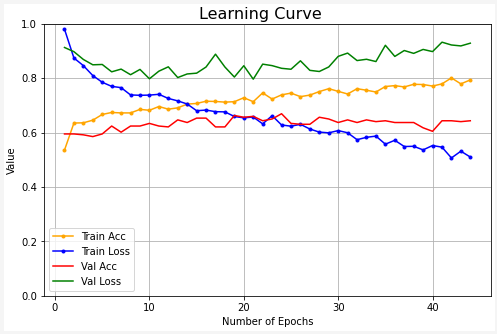


Validation set
loss: 0.8369725346565247
accuracy: 0.6699029207229614


In [51]:
# Run LSTM model

seed_value = 2
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

history_1stm, model_1stm = run_model_functions (actfn, 100, batch_size,  LSTM_Model())
history_plot(history_1stm) 

print()

lstm_accuracy, lstm_loss = evaluate_models(model_1stm)

In [52]:
from tabulate import tabulate

table = [['Neural Network Models', 'Accuracy' , 'Loss'], 
         ['Convolutional Neural Networks', cnn_accuracy, cnn_loss], 
         ['Long Short-Term Memory Networks', lstm_accuracy, lstm_loss]]

In [53]:
print(tabulate(table))

-------------------------------  ------------------  ------------------
Neural Network Models            Accuracy            Loss
Convolutional Neural Networks    0.5954692363739014  0.9658093452453613
Long Short-Term Memory Networks  0.6699029207229614  0.8369725346565247
-------------------------------  ------------------  ------------------


### Let's test the LSTM model on testing data

In [54]:
y_pred = model_1stm.predict(x_testing)

In [55]:
# classification_report
report = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1) ,target_names=["negative", "neutral","positive"],labels = [0,1,2])
print(report)

              precision    recall  f1-score   support

    negative       0.61      0.35      0.45       159
     neutral       0.38      0.18      0.24        90
    positive       0.73      0.93      0.82       424

    accuracy                           0.69       673
   macro avg       0.57      0.49      0.50       673
weighted avg       0.66      0.69      0.65       673



### Based on the results we can see that LSTM is performing better than CNN in both aspects, Accuracy is increased and loss is decreased. 

### Now let's check textblob library :- 
- Sentiment analysis is a feature that comes standard with the TextBlob library. It takes a "bag-of-words" approach, which means that it contains a list of terms with sentiment scores associated with them, including "fine," "poor," and "excellent." Additionally, it can recognise intensifiers like "very" and modifiers like "not" that have an impact on the sentiment score.

In [56]:
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

In [57]:
df_train.head()

,text,processed_text,text_length,sentiment
2791,who cuisine at fine,cuisine fine,2,positive
988,Pizza crust like ! - pizza,pizza crust like pizza,4,positive
1890,priced well,priced well,2,positive
573,a good wine,good wine,2,positive
1267,and prices mediocre . the here,price mediocre,2,neutral


In [58]:
df_train['Subjectivity'] = df_train['processed_text'].apply(getSubjectivity) 
df_train['Polarity'] = df_train['processed_text'].apply(getPolarity) 
df_train['Analysis'] = df_train['Polarity'].apply(analysis)
df_train.head()

,text,processed_text,text_length,sentiment,Subjectivity,Polarity,Analysis
2791,who cuisine at fine,cuisine fine,2,positive,0.5,0.416667,positive
988,Pizza crust like ! - pizza,pizza crust like pizza,4,positive,0.0,0.000000,neutral
1890,priced well,priced well,2,positive,0.0,0.000000,neutral
573,a good wine,good wine,2,positive,0.6,0.700000,positive
1267,and prices mediocre . the here,price mediocre,2,neutral,1.0,-0.500000,negative


In [59]:
df_test['Subjectivity'] = df_test['processed_text'].apply(getSubjectivity) 
df_test['Polarity'] = df_test['processed_text'].apply(getPolarity) 
df_test['Analysis'] = df_test['Polarity'].apply(analysis)
df_test.head()

,text,processed_text,text_length,sentiment,Subjectivity,Polarity,Analysis
634,people obviously pizzas their,people obviously pizza,3,positive,0.5,0.0,neutral
1325,"is , tapas always yummy with . the",tapa always yummy,3,positive,0.0,0.0,neutral
1980,the same classical made,classical made,2,positive,0.0,0.0,neutral
743,"dinner a late , raucus",dinner late raucus,3,positive,0.6,-0.3,negative
929,the lamb and naan,lamb naan,2,positive,0.0,0.0,neutral


In [60]:
y_pred = df_test['Analysis']
y_actual = df_test['sentiment']


In [62]:
target_names = ['negative', 'neutral' , 'positive']
print(metrics.classification_report(y_actual, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.52      0.26      0.34       159
     neutral       0.21      0.69      0.32        90
    positive       0.85      0.59      0.70       424

    accuracy                           0.53       673
   macro avg       0.53      0.51      0.45       673
weighted avg       0.68      0.53      0.56       673



- F1 score for positive reviews is great but the neutral and negative are not looking good that might be because of the class imbalace, amount of positive reviews are much higher than the amount of negative and neutral combined